<H1 align="center">Выпускной проект.<br><br>Сегментация пользователей банка по потреблению.</H1><br><br>

**Задание:**<br>
*Проанализируйте клиентов регионального банка «Метанпром» и сегментируйте их по количеству потребляемых продуктов.*

**Цель исследования:**<br>
*Предотвратить отток клиентов банка.*

**Описание данных:**<br>
*Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.*<br>
*Колонки:*
- **user_id** — *идентификатор пользователя,*
- **score** — *баллы кредитного скоринга,*
- **city** — *город,*
- **gender** — *пол,*
- **age** — *возраст,*
- **objects** — *количество объектов в собственности,*
- **balance** — *баланс на счёте,*
- **products** — *количество продуктов, которыми пользуется клиент,*
- **credit_card** — *есть ли кредитная карта,*
- **loyalty** — *активность (лояльность) клиента:*
 - **0** — *неактивный клиент*,
 - **1** — *активный клиент*,
- **estimated_salary** — *заработная плата клиента,*
- **churn** — *ушёл или нет:*
 - **0** — *остался*,
 - **1** — *ушёл в отток*.

**Оглавление:**<br>

1. [Загрузка данных.](#num1) <br>
2. [Предобработка данных.](#num2) <br>
   2.1 [Вывод.](#num21) <br>
3. [Исследовательский анализ данных.](#num3) <br>
   3.1 [Вывод.](#num31) <br>
4. [Проверка гипотез.](#num4) <br>
   4.1 [Проверим гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.](#num41) <br>
   4.2 [Проверим гипотезу различия кредитного рейтинга между клиентами которые ушли и которые остались.](#num42) <br>
5. [Общий вывод и рекомендации.](#num5) <br>
6. [Подготовка презентации.](#num6) <br>


<a id="num1"></a>
## Загрузка данных.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
from scipy import stats as st

# визуализация
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go

# магическая команда, отображает и сохраняет графики в блокноте
%matplotlib inline
# рендеринг изображений с более высоким разрешением для MacBook
%config InlineBackend.figure_format='retina'

<br><font size=3>Загрузим данные.</font>

In [2]:
# назначим переменную для датафрейма 
path_to_file = 'bank_dataset.csv'

# составим список новых имён колонок
col_names = ['user_id',
             'score',
             'city',
             'gender',
             'age',
             'objects',
             'balance',
             'products',
             'credit_card',
             'loyalty',
             'estimated_salary',
             'churn',
            ]

# прочтём датафрейм
data = pd.read_csv(path_to_file,
                   sep=',',                         # символ табуляции передадим параметром 'sep'
                   header = 0,                      # сначала удаляем имена колонок (заголовок)
                   names=col_names,                 # затем назначаем новые имена колонок (переименуем колонки)
                   index_col='user_id',             # назначим колонку 'user_id' в качестве индекса
                  )

# для удобства, переставим местами колонки датафрейма
data = data[
    ['city',
     'gender',
     'age',
     'objects',
     'credit_card',
     'estimated_salary',
     'balance',
     'score',
     'products',
     'loyalty',
     'churn',
    ]
]

df = data.copy()

pd.set_option(
    'display.max_columns', None,                   # лимит на отображаемое количество колонок
    'display.max_colwidth', None,                  # максимальная ширина столбца для таблиц
    'display.max_rows', None,                      # лимит на отображаемое количество строк
    'display.width', 2000,                         # ширина дисплея в символах
    'display.float_format', '{:20,.2f}'.format,    # избавляемся от экспоненциальной записи)
             )

<a id="num2"></a>
## Предобработка данных.

<font size=3>Напишем необходимые функции</font>

In [3]:
# функции для выделения текста цветом (восьмеричные escape-символы '\ 033')
def colorRB(colorR, colorB): print("\033[1;91m {} \033[0m \033[1;90m {} \033[0m".format(colorR, colorB))
def colorR(colorR): print("\033[1;91m {} \033[0m" .format(colorR))
def colorB(colorB): print("\033[1;98m {} \033[0m" .format(colorB))

In [4]:
def datainfo(data):
    
    """
    функция для получения основной информации о датафрейме, 
    функции передаётся датафрейм
    
    """
    
    # переменные для выделения цветом (восьмеричные escape-символы '\ 033')
    BB = '\033[1;90m'          # Черный, жирный цвет
    BR = '\033[1;91m'          # Красный, жирный цвет
    Clr_Off = '\033[0m'        # Сброс выделения (ставится в конце выделяемой строки)
    
    # отображение датафрейма без ограничения количества строк и колонок только в этой ячейке
    with pd.option_context('display.max_columns', None,               # лимит на изображаемое количество колонок
                           'display.max_colwidth', None,                  # максимальная ширина столбца для таблиц
                           'display.max_rows', None,                      # лимит на изображаемое количество строк
                           'display.width', 2000,                         # ширина дисплея в символах
                           'display.precision', 3,                        # точность отображения вывода в десятичных разрядах
                           'display.float_format', '{:20,.2f}'.format,    # избавляемся от экспоненциальной записи
                          ):
        
        print(BR + '\n\nСтруктура датафрейма:' + Clr_Off, end='\n\n')
        display(data.info())
        print()
            
        print(BR + '\n\nДатафрейм:' + Clr_Off)
        display(data.sample(5))
        
        # количество пропущенных значений
        data_full_isna = data.isna()
        if data_full_isna.sum().sum() == 0:
            print(BR + '\n\nОбщее количество пропущенных значений: ' + Clr_Off, BB, data_full_isna.sum().sum(), Clr_Off)
        else:
            # найдём все пропуски в процентном отношении ко всему датафрейму
            print(BR + '\n\nОбщее количество пропущенных значений: ' + Clr_Off, BB, data_full_isna.sum().sum(), Clr_Off)
            print(BR + '\nПроцент пропущенных значений в колонках: \n' + Clr_Off)
            print(round(data[data.columns].isna().sum(axis=0) / len(data)*100, 1).apply( lambda x : str(x) + '%'))
            
        # количество дубликатов
        data_full_duplicated = data.duplicated().sum()
        if data_full_duplicated == 0:
            print(BR + '\n\nОбщее количество дубликатов: ' + Clr_Off, BB, data_full_duplicated, Clr_Off)
        else:
            print(BR + '\n\nОбщее количество дубликатов: ' + Clr_Off, BB, data_full_duplicated, Clr_Off)
            # процент дубликатов
            print(BR + f'Общий процент дубликатов: ' + Clr_Off, BB, f'{data_full_duplicated / len(data):.1%}', Clr_Off)
            # количество полных дубликатов по колонкам
            print(BR + '\nКоличество дубликатов в колонках: ' + Clr_Off)
            display(data[data.duplicated()].iloc[:, 0].value_counts())
                
        # количество уникальных значений в датафрейме
        print(BR + '\n\nКоличество уникальных значений в датафрейме:' + Clr_Off)
        display(data.nunique())

In [5]:
def describe(data):
    
    """статистические показатели датафрейма, 
       с помощью менеджера контекста, избавимся 
       от экспоненциальной записи
    """
    
    # переменные для выделения текста цветом (восьмеричные escape-символы \ 033)
    BB = '\033[1;90m'          # Черный
    BR = '\033[1;91m'          # Красный
    Clr_Off = '\033[0m'        # Сброс цвета текста (ставится в конце текста)
    
    print(BR + '\n\nСтатистические показатели датафрейма:' + Clr_Off)
    with pd.option_context('display.float_format', '{:.2f}'.format):    # избавляемся от экспоненциальной записи
        display(data.describe(datetime_is_numeric=True).T)

<br><font size=3>Выведем на экран основную информации о датафрейме.</font>

In [6]:
datainfo(df)



Структура датафрейма:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15677338 to 15671055
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              10000 non-null  object 
 1   gender            10000 non-null  object 
 2   age               10000 non-null  int64  
 3   objects           10000 non-null  int64  
 4   credit_card       10000 non-null  int64  
 5   estimated_salary  10000 non-null  float64
 6   balance           6383 non-null   float64
 7   score             10000 non-null  int64  
 8   products          10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


None




Датафрейм:


,city,gender,age,objects,credit_card,estimated_salary,balance,score,products,loyalty,churn
user_id,,,,,,,,,,,
15806361,Рыбинск,М,41,9,1,"152,153.74",NaN,793,2,0,0
15637614,Рыбинск,Ж,41,5,1,"69,586.27","28,082.95",661,1,0,1
15697637,Ярославль,М,51,10,1,"130,189.53","141,556.96",733,1,0,0
15793665,Рыбинск,М,39,8,1,"99,654.13",NaN,702,2,0,0
15731687,Ростов Великий,М,43,8,0,"148,412.24","119,654.44",789,2,1,1




Общее количество пропущенных значений:   3617 

Процент пропущенных значений в колонках: 

city                 0.0%
gender               0.0%
age                  0.0%
objects              0.0%
credit_card          0.0%
estimated_salary     0.0%
balance             36.2%
score                0.0%
products             0.0%
loyalty              0.0%
churn                0.0%
dtype: object


Общее количество дубликатов:   0 


Количество уникальных значений в датафрейме:


city                   3
gender                 2
age                   70
objects               11
credit_card            2
estimated_salary    9999
balance             6381
score                460
products               4
loyalty                2
churn                  2
dtype: int64

<br><font size=3>Выведем на экран статистические показатели датафрейма.</font>

In [7]:
describe(df)



Статистические показатели датафрейма:


,count,mean,std,min,25%,50%,75%,max
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
credit_card,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


<br><font size=3>Колонку 'products' привидём к категориальному типу, а 'estimated_salary' к целочисленному.</font>

In [8]:
# методом astype() приведём колонку 'products' к категориальному типу, а 'estimated_salary' к целочисленному
df = df.astype({'products': 'category', 'estimated_salary': 'int'})
colorR('\n\nСтруктура датафрейма после преобразования:\n')
display(df.info())

 

Структура датафрейма после преобразования:
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15677338 to 15671055
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   city              10000 non-null  object  
 1   gender            10000 non-null  object  
 2   age               10000 non-null  int64   
 3   objects           10000 non-null  int64   
 4   credit_card       10000 non-null  int64   
 5   estimated_salary  10000 non-null  int32   
 6   balance           6383 non-null   float64 
 7   score             10000 non-null  int64   
 8   products          10000 non-null  category
 9   loyalty           10000 non-null  int64   
 10  churn             10000 non-null  int64   
dtypes: category(1), float64(1), int32(1), int64(6), object(2)
memory usage: 830.3+ KB


None

<br><font size=3>Переименуем значения колонки 'gender'</font>

In [9]:
# переименуем значения колонки 'gender' методом replace()
df['gender'] = df['gender'].str.replace('Ж', 'F').replace('М', 'M')

display(df.sample(5))

,city,gender,age,objects,credit_card,estimated_salary,balance,score,products,loyalty,churn
user_id,,,,,,,,,,,
15647272,Ростов Великий,F,31,4,0,61936,"164,672.66",850,1,1,0
15853447,Ростов Великий,M,37,4,1,52367,"138,476.41",684,2,1,0
15678013,Рыбинск,M,47,7,1,189310,"142,643.54",605,1,0,0
15783164,Ярославль,F,35,1,0,92131,NaN,507,2,0,0
15814271,Рыбинск,F,37,9,1,68008,NaN,794,2,0,0


<br><font size=3>Cоздадим отдельный датафрейм с пропускамии и сделаем анализ.</font>

In [10]:
# составим датафрейм на основе пропущенных значений
balance_nan = df[df['balance'].isnull()]

display(balance_nan.head())

,city,gender,age,objects,credit_card,estimated_salary,balance,score,products,loyalty,churn
user_id,,,,,,,,,,,
15677338,Ярославль,F,42,2,1,101348,NaN,619,1,1,1
15744090,Ярославль,F,39,1,0,93826,NaN,699,2,0,0
15635267,Ярославль,M,50,7,1,10062,NaN,822,2,1,0
15779909,Рыбинск,M,24,3,1,76390,NaN,497,2,0,0
15675000,Ярославль,F,34,10,1,26260,NaN,476,2,0,0


In [11]:
# посмотрим распределение пропусков среди значений колонки 'city'
colorR('Количество пропусков колонки "city":')
display(balance_nan['city'].value_counts())

# доля пропусков значений колонки 'city'
colorR('Доля пропусков значений колонки "city":')
display((balance_nan['city'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

 Количество пропусков колонки "city": 


Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

 Доля пропусков значений колонки "city": 


Ярославль    66.85 %
Рыбинск      33.15 %
Name: city, dtype: object

*Пропуски в значениях колонки 'balance' встречаются в 2 городах из 3, больше всего в Ярославле — **2418**, что в процентном соотношении составляет: в Ярославле — **66.85%** и в Рыбинске — **33.15%**.*

In [12]:
# посмотрим распределение пропусков среди значений колонки 'churn'
colorR('Распределение пропусков среди значений колонки "churn":')
display(balance_nan['churn'].value_counts())

# доля пропусков значений колонки 'churn'
colorR('Доля пропусков значений колонки "churn":')
display((balance_nan['churn'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

 Распределение пропусков среди значений колонки "churn": 


0    3117
1     500
Name: churn, dtype: int64

 Доля пропусков значений колонки "churn": 


0    86.18 %
1    13.82 %
Name: churn, dtype: object

*Пропуски в значениях колонки 'balance' в 6 раз выше среди НЕ отточных клиентов — **3117**, в процентном соотношении, доля пропусков НЕ отточных клиентов на **72%** выше отточных.*

In [13]:
# посмотрим распределение пропусков среди значений колонки 'loyalty'
colorR('Распределение пропусков среди значений колонки "loyalty":')
display(balance_nan['loyalty'].value_counts())

# доля пропусков значений колонки 'loyalty'
colorR('Доля пропусков значений колонки "loyalty":')
display((balance_nan['loyalty'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

 Распределение пропусков среди значений колонки "loyalty": 


1    1873
0    1744
Name: loyalty, dtype: int64

 Доля пропусков значений колонки "loyalty": 


1    51.78 %
0    48.22 %
Name: loyalty, dtype: object

*Пропуски в значениях колонки 'balance' почти не коррелируют с колонкой 'loyalty'.*

In [14]:
# посмотрим распределение пропусков среди значений колонки 'credit_card'
colorR('Распределение пропусков среди значений колонки "credit_card":')
display(balance_nan['credit_card'].value_counts())

# доля пропусков значений колонки 'credit_card'
colorR('Доля пропусков значений колонки "credit_card":')
display((balance_nan['credit_card'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

 Распределение пропусков среди значений колонки "credit_card": 


1    2592
0    1025
Name: credit_card, dtype: int64

 Доля пропусков значений колонки "credit_card": 


1    71.66 %
0    28.34 %
Name: credit_card, dtype: object

*Пропусков в значениях колонки 'balance' в 2.5 раза больше у пользователей кредитных карт — **2592**, что в процентном соотношении составляет — **72%** и **28%** у не пользователей.*

In [15]:
# посмотрим распределение пропусков среди значений колонки 'products'
colorR('Распределение пропусков среди значений колонки "products":')
display(balance_nan['products'].value_counts())

# доля пропусков значений колонки 'products'
colorR('Доля пропусков значений колонки "products":')
display((balance_nan['products'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

 Распределение пропусков среди значений колонки "products": 


2    2600
1     905
3      98
4      14
Name: products, dtype: int64

 Доля пропусков значений колонки "products": 


2    71.88 %
1    25.02 %
3     2.71 %
4     0.39 %
Name: products, dtype: object

*Пропусков в значениях колонки 'balance' почти в 3 раза больше у клиентов, пользующихся двумя продуктами — **2600**, в процентном соотношении, доля пропусков клиентов, пользующихся двумя продуктами — **72%**.<br><br>
По-видимому, пропуски связаны с ошибкой заполнения данных в городах **Ярославль** и **Рыбинск**, когда кредитная карта с нулевым балансом, ошибочно принимается за дебетовую.*

<a id="num21"></a>
### Вывод.

Датафрейм состоит из **11** колонок и содержит **10000** записей.<br>
В колонке **'balance'** обнаруженно **3617** пропущенных значений, что составляет **36.2%** от размера датафрейма, поэтому мы не можем их удалить.<br> 
По-видимому, пропуски связаны с ошибкой заполнения данных в городах **Ярославль** и **Рыбинск**, когда кредитная карта с нулевым балансом, ошибочно принимается за дебетовую.<br>
Дубликаты не обнаруженны.<br>
Колонку **'products'**, мы привели к категориальному типу, чтобы не путаться при вычислениях.<br>
Для удобочитаемости были переименованы значения колонки **'gender'**.
<br><br>
Возраст клиентов банка находится в пределах от **18** до **92** лет, средний возраст клиента **39** лет.<br>
Количество объектов в собственности от **0** до **10** (в среднем **5**).<br>
Количество продуктов, которыми пользуется клиент от **1** до **4**. Банковский счёт, кредитная карта также относятся к продуктам банка.<br>
Кредитной картой пользуются в среднем, **71%** клиентов банка.<br>
Кредитный рейтинг в среднем сосавляет **650** баллов.<br>
В отток уходят, в среднем, **20%** клиентов банка, что очень много.<br>


<a id="num3"></a>
## Исследовательский анализ данных.

<br><font size=3>Посмотрим, какие значения датафрейма коррелируют межу собой. </font>

In [16]:
# матрица корреляций
def buildCorr(data, title):
    # воспользуемся бинарным стилем категоризации ('One-Hot' кодирование)
    df_dumm = pd.get_dummies(data)
    # построим матрицу корреляции
    plt.figure(figsize=(14, 12))
    matrix = np.triu(df_dumm.corr())
    ax = sns.heatmap(df_dumm.corr(), annot=True, fmt='.0%', square=True, mask=matrix, cmap='vlag', center=0)
    plt.title(title, fontsize = 16)

    plt.show()

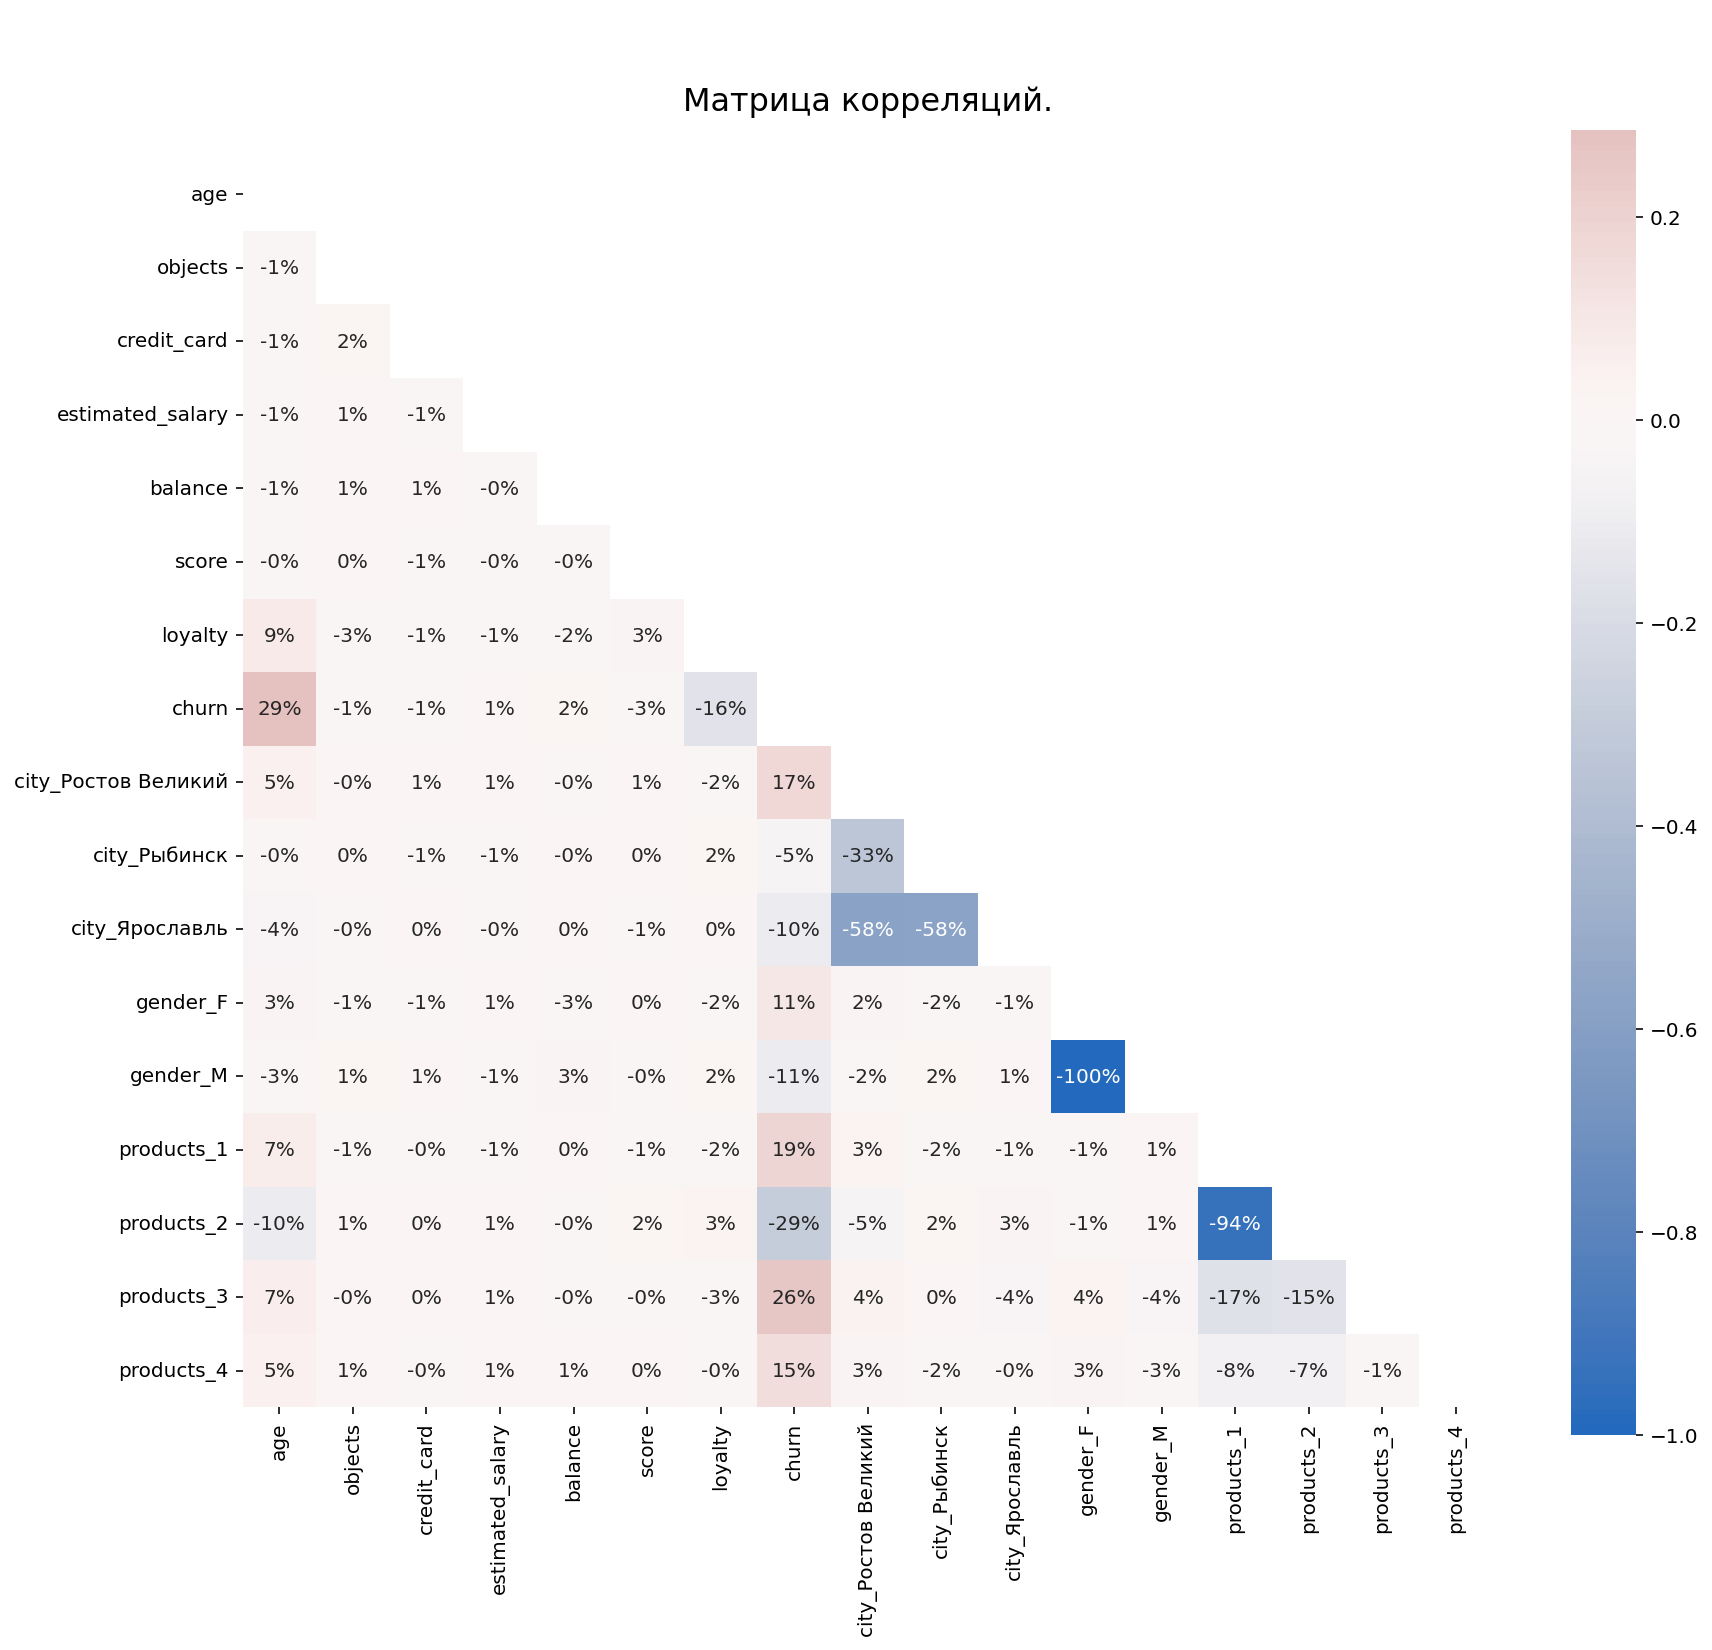

In [17]:
buildCorr(df, '\n\nМатрица корреляций.\n')

> *На матрице корреляции можно заметить корреляцию между колонкиами:*
- *'churn' и 'age' — (29%)*
- *'churn' и 'loyalty' — (-16%)*
- *'churn' и 'city' Ростов Великий — (17%)*
- *'products_1' и 'products_2'  — (-94%)*
- *'churn' и 'products':*
 - *'churn' и 'products_1'  — (19%)*
 - *'churn' и 'products_2'  — (-29%)*
 - *'churn' и 'products_3'  — (26%)*
 - *'churn' и 'products_4'  — (15%)*
- *'city':*
 - *Ярославль и Рыбинск — (-58%)*
 - *Ярославль и Ростов Великий — (-58%)*
 - *Рыбинск и Ростов Великий — (-33%)*


<br><font size=3>Нас интерисует колонка оттока, выделим её из матрицы корреляции.</font>

In [18]:
# напишем функцию для выделения колонки из матрицы корреляций
def buildCorr_Col(data, column, title):
    # воспользуемся бинарным стилем категоризации ('One-Hot' - кодирование)
    df_dumm = pd.get_dummies(data)
    # построим матрицу корреляции
    df_corr = df_dumm.corr()
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(df_corr.loc[:, [column]].drop(column).sort_values(column), annot=True, fmt='.0%', cmap='vlag', center=0)
    plt.title(title, fontsize = 16)
    plt.show()

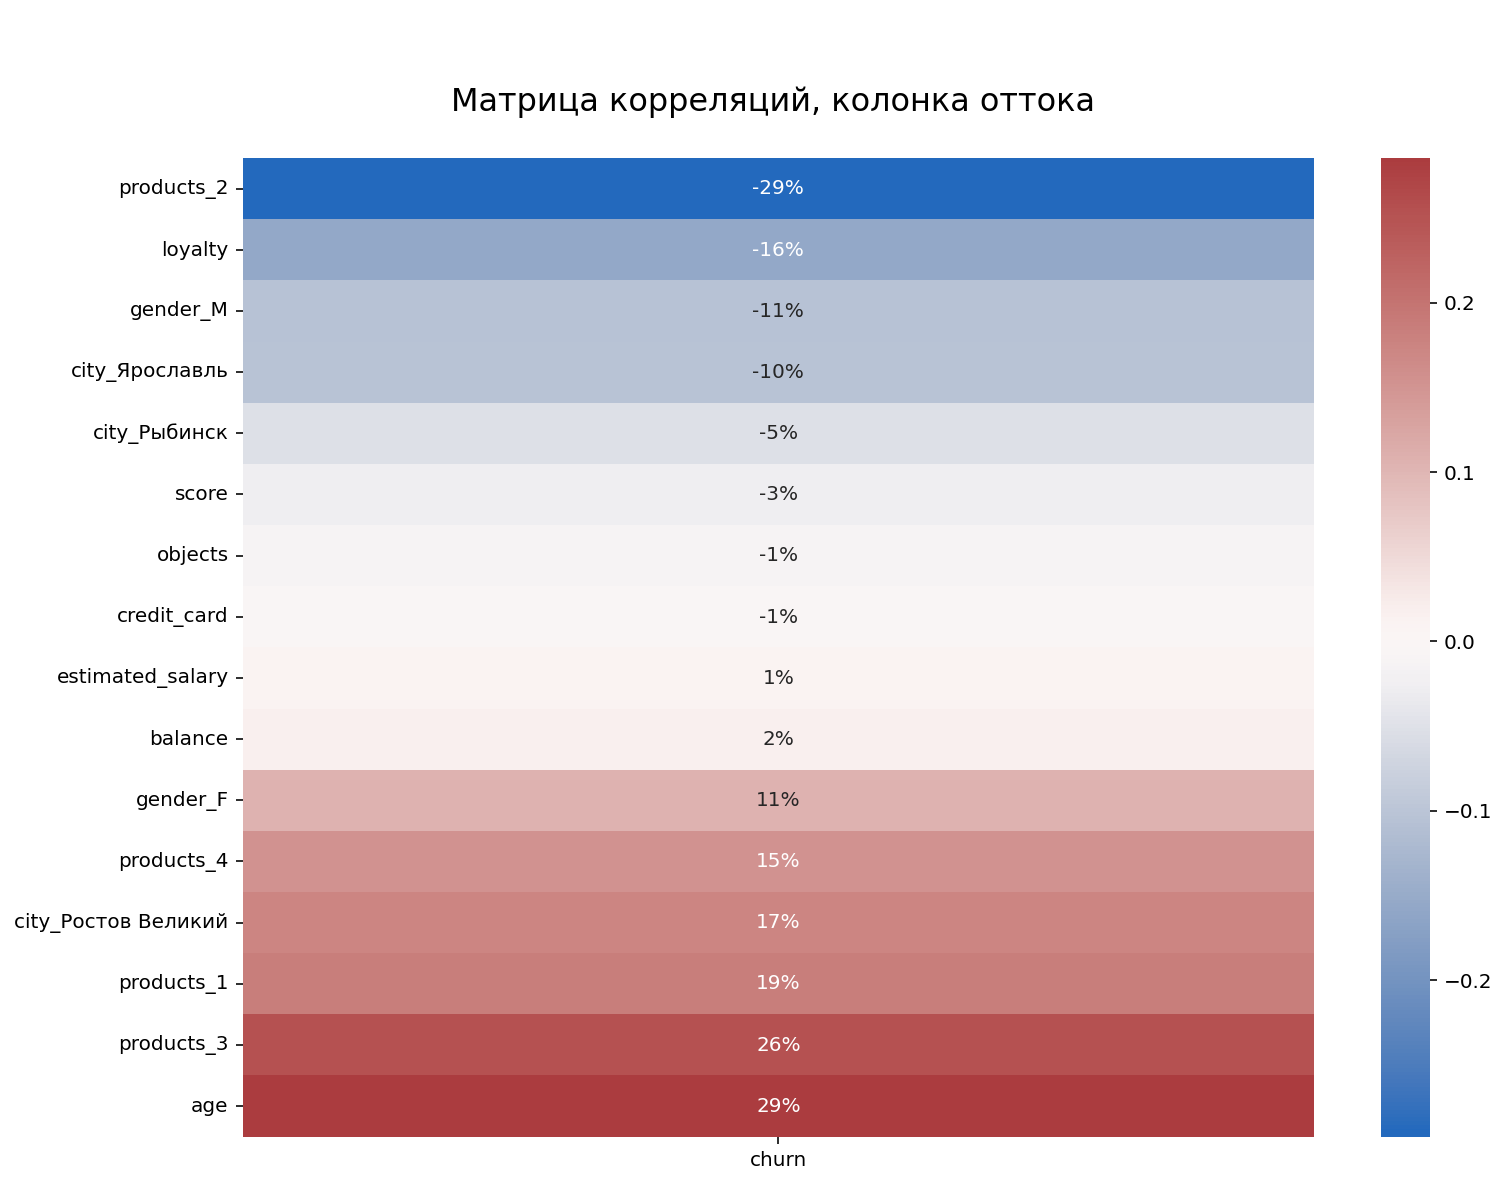

In [19]:
buildCorr_Col(df, 'churn', '\n\nМатрица корреляций, колонка оттока \n')

*По оттоку клиентов у нас лидирует колонки:*
- *'age' — 29%*
- *'products_3' — 26%*
- *'products_1' — 19%*
- *'Ростов Великий' — 17%*
- *'products_4' — 15%*
- *'gender_F' — 11%*

*Соответственно, обратная корреляция («приток» клиентов), наблюдается в колонках:*
- *'products_2' — (-29%)*
- *'loyalty' — (-16%)*
- *'gender_M' — (-11%)*
- *'Ярославль' — (-10%)*
- *'Рыбинск' — (-5%)*

<br><font size=3>Уточним полученные данные, построим многосегментный (парный) график разброса.</font>

<Figure size 720x576 with 0 Axes>

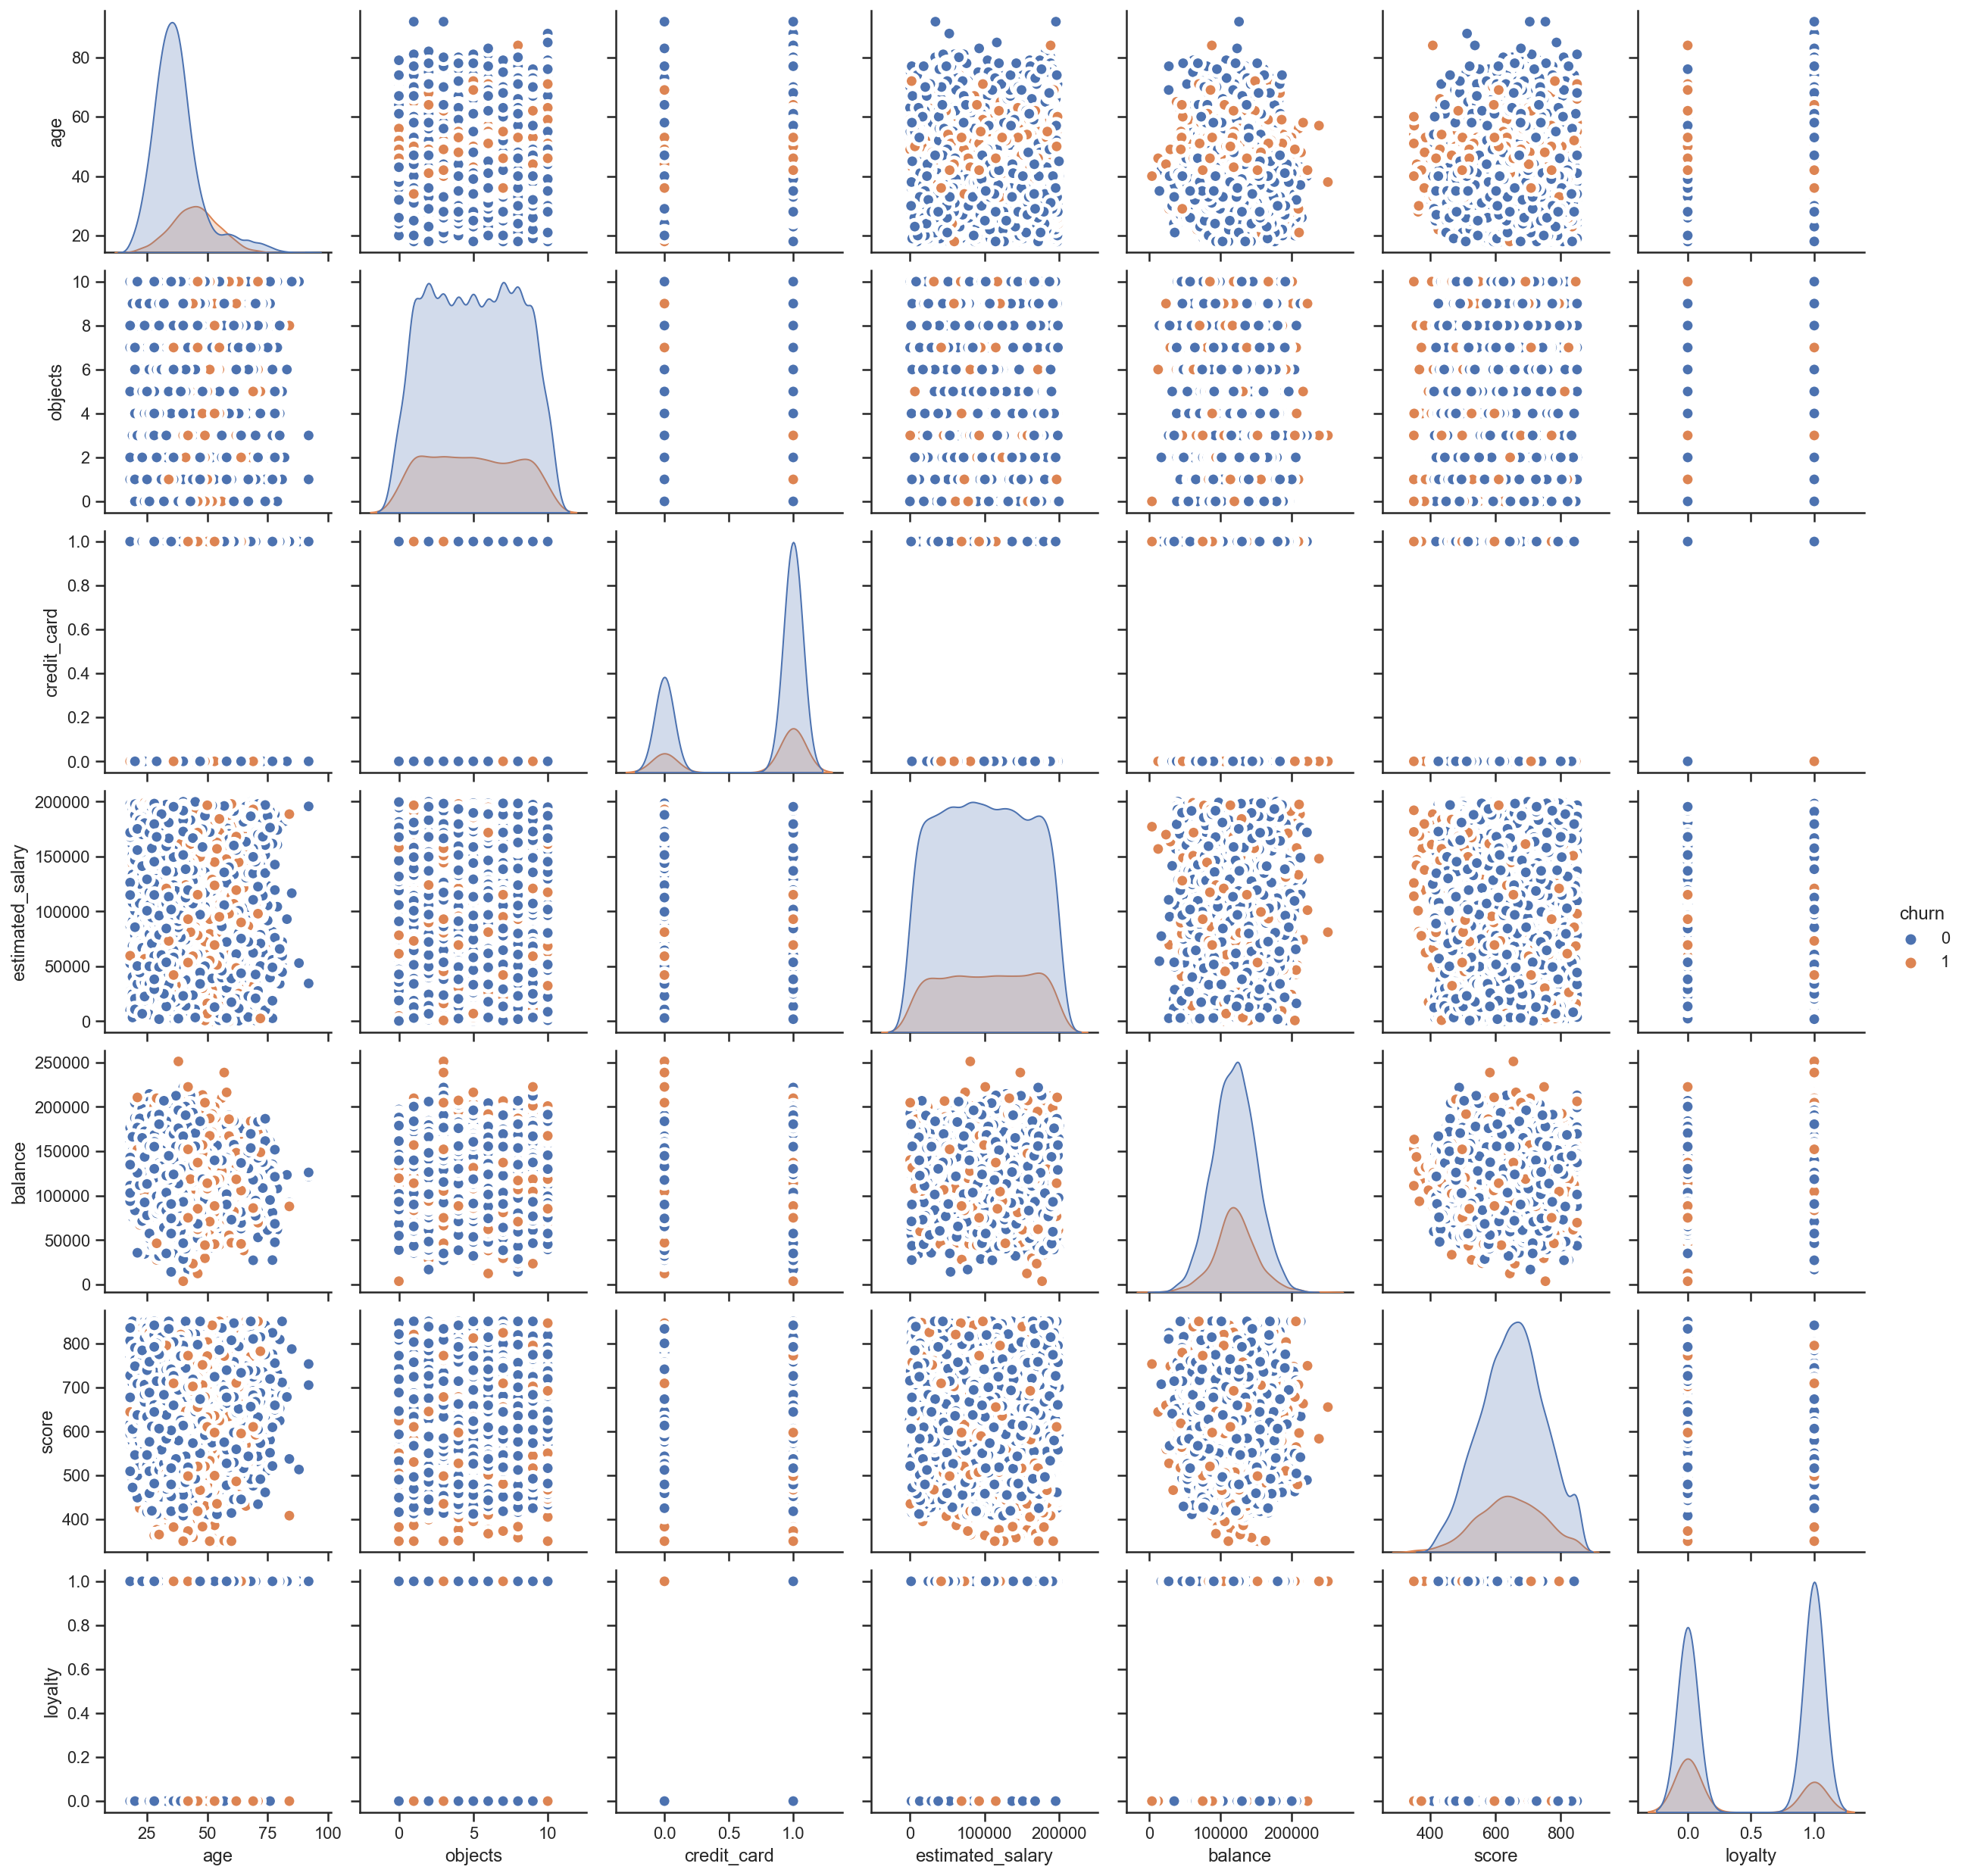

In [20]:
# построим диаграмму pairplot() из библиотеки seaborn
plt.figure(figsize=(10,8))
sns.set(style="ticks")
sns.pairplot(df, kind="scatter", hue="churn", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))

plt.show()

*В целом, распределение данных в датафрейме похоже на нормальное, распределение в колонке 'age' имеет положительную ассиметрию. Кредитный рейтинг 'score' ниже 400 и возраст клиента 40-50 лет, увеличивают вероятность оттока.*

<br><font size=3><br>Посмотрим в каких городах происходит наибольший отток.</font>

In [21]:
# сгруппируем датафрейм по колонке 'city' и посчитаем отток
display(df.groupby(['city']).agg({'churn': ['sum', 'mean']}).style.background_gradient(cmap='Blues', axis=1))

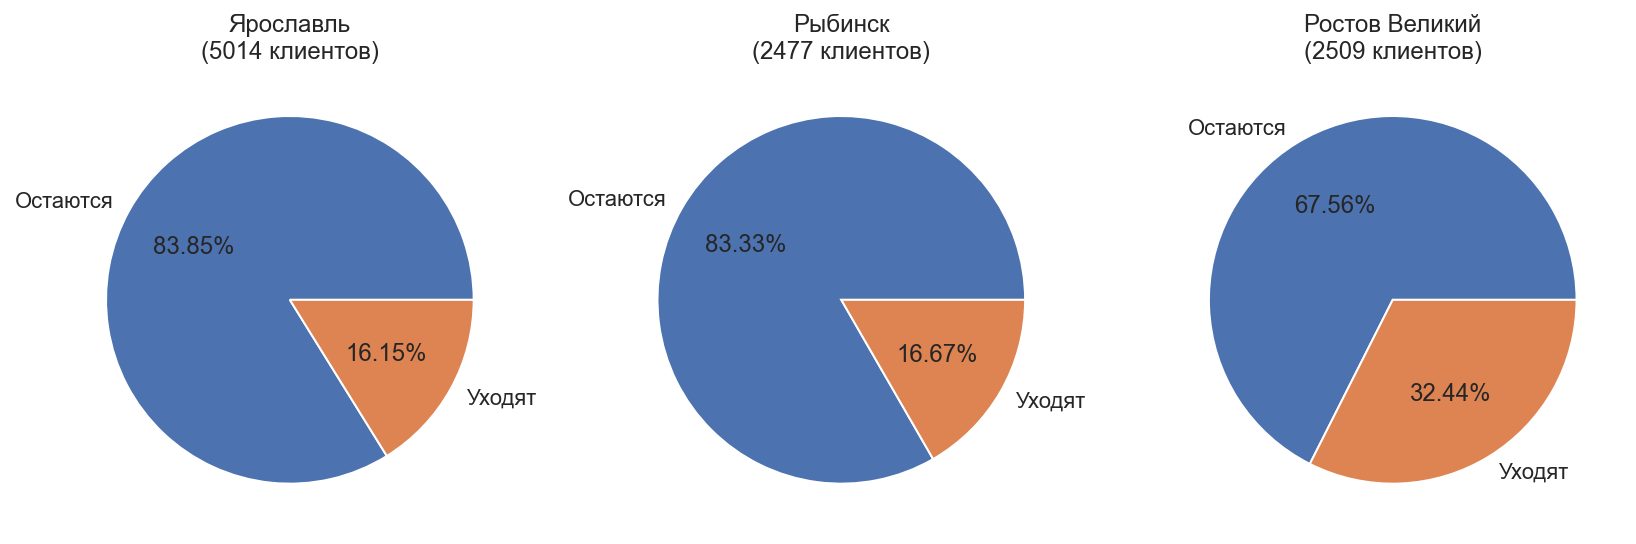

In [22]:
# построим круговые диаграммы
cityes = df.city.unique()
fig, axs = plt.subplots(1, len(cityes), sharey=False, figsize=(14, 5))
for i, city in enumerate(cityes):
    df_temp = df.query('city == @city').churn.value_counts()
    df_temp.plot(kind='pie',
                 ax=axs[i],
                 labels=['Остаются', 'Уходят'],
                 ylabel="",
                 autopct='%1.2f%%',
                ).set(title=f'{city}\n({df_temp.sum()} клиентов)')
    
plt.show()

*Количественно, наибольший отток произошёл в Ярославле – **16.2%**. Однако, относительно численности населения, по оттоку лидирует Ростов Великий, количество отточных клиентов достигает – **32.4%**.*

<br><font size=3>Посмотрим на каком количестве продуктов происходит наибольший отток.</font>

In [23]:
# сгруппируем датафрейм по колонке 'products' и посчитаем отток
display(df.groupby(['products']).agg({'churn': ['sum', 'mean']}).style.background_gradient(cmap='Blues', axis=1))

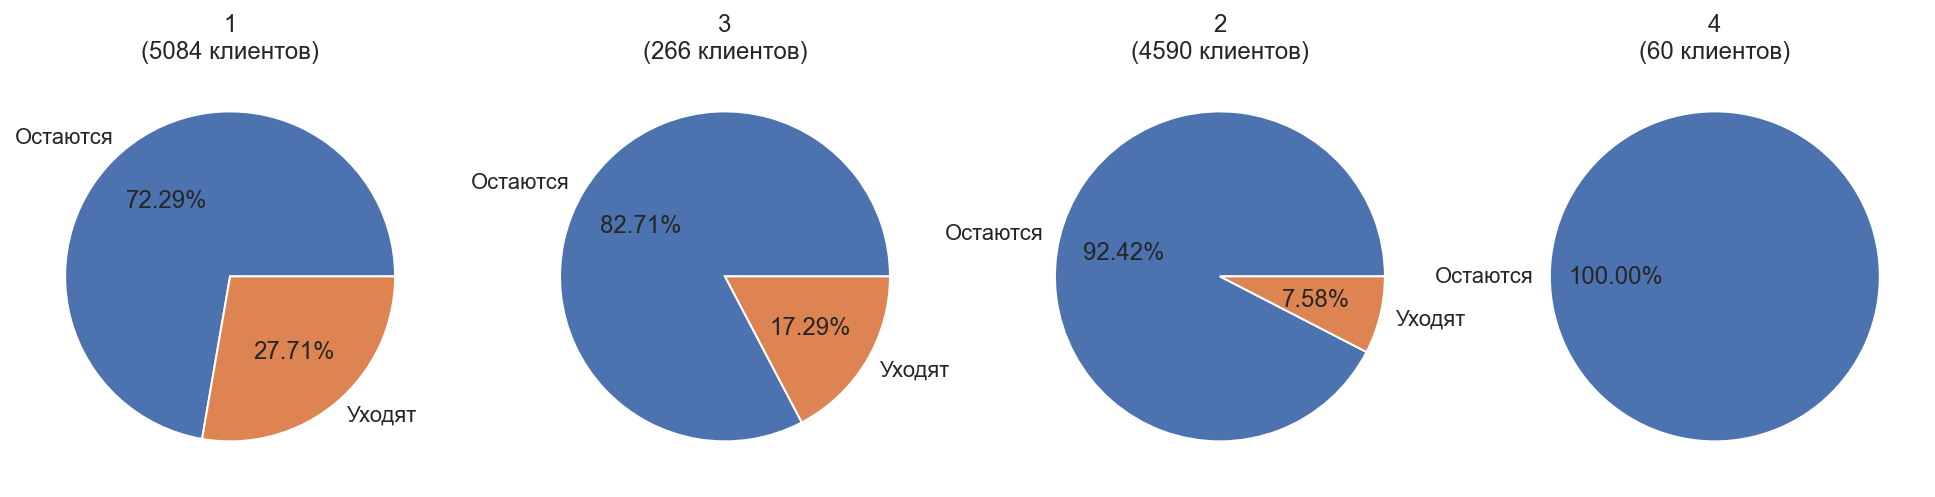

In [24]:
# построим круговые диаграммы
product = df.products.unique()

fig, axs = plt.subplots(1, len(product), sharey=False, figsize=(17, 14))
for i, products in enumerate(product):
    df_temp = df.query('products == @products').churn.value_counts()
    df_temp.plot(kind='pie',
                 ax=axs[i],
                 labels=['Остаются', 'Уходят'],
                 ylabel="",
                 autopct='%1.2f%%',
                ).set(title=f'{products}\n({df_temp.sum()} клиентов)')
    
plt.show()


*Колличественно, наибольший отток происходит у клиентов использующих один продукт — **27.7%** от 5084 клиентов банка, наименьший у клиентов использующих по **3** и **4** продукта.*<br>
*Однако, клиенты, использующие по **3** и **4** продукта, почти полностью уходят в отток — **82.7%** и **100%** соответственно, причём колличество клиентов, использующих по **3** и **4** продукта, очень небольшое.* <br>
*Самыми стабильными остаются клиенты имеющие два продукта банка.*

<br><font size=3><br>Посмотрим, как распределяется отток среди мужчин и женщин.</font>

In [25]:
# сгруппируем датафрейм по колонке 'gender' и посчитаем отток
display(df.groupby(['gender']).agg({'churn': ['sum', 'mean']}).style.background_gradient(cmap='Blues', axis=1))

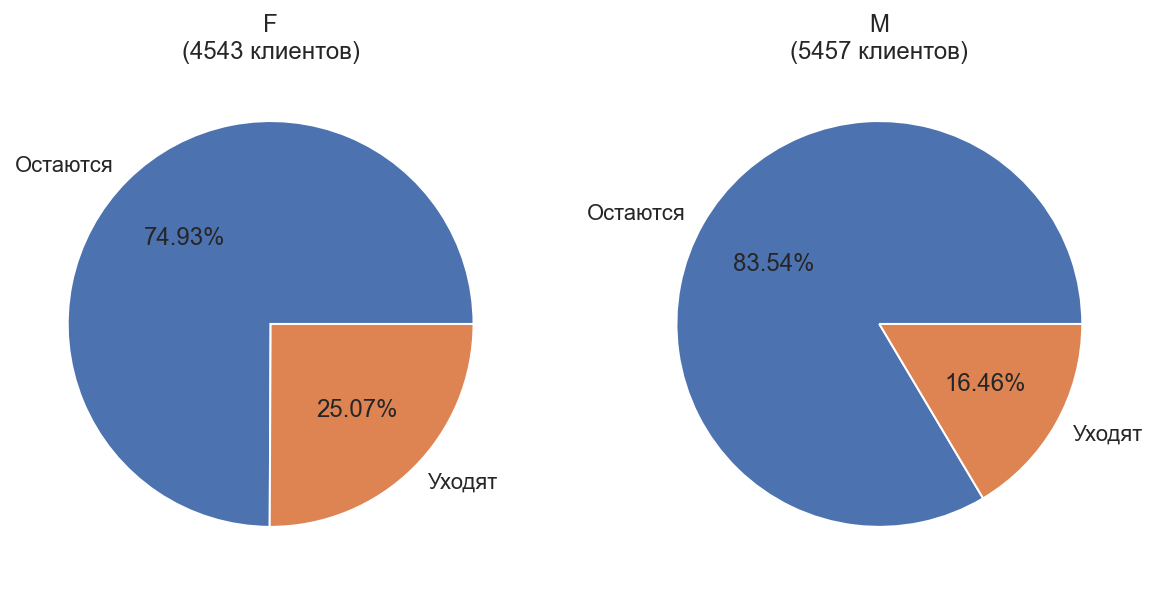

In [26]:
# построим круговые диаграммы
genders = df.gender.unique()

fig, axs = plt.subplots(1, len(genders), sharey=False, figsize=(10, 10))
for i, gender in enumerate(genders):
    df_temp = df.query('gender == @gender').churn.value_counts()
    df_temp.plot(kind='pie',
                 ax=axs[i],
                 labels=['Остаются', 'Уходят'],
                 ylabel="",
                 autopct='%1.2f%%',
                ).set(title=f'{gender}\n({df_temp.sum()} клиентов)')
    
plt.show()

*Среди женщин - клиентов банка, отток чаще распространён (**25.1%**), чем среди мужчин - клиентов (**16.5%**).*

<br><font size=3><br>Посмотрим на какой возраст приходится наибольший отток.</font>

In [27]:
# сгруппируем датафрейм по колонке 'age' и посчитаем отток
display(df.groupby('age', as_index=False, sort=False )
        .agg({'churn': ['sum', 'mean']}).head()
        .style.background_gradient(cmap='Blues', axis=1)
       )

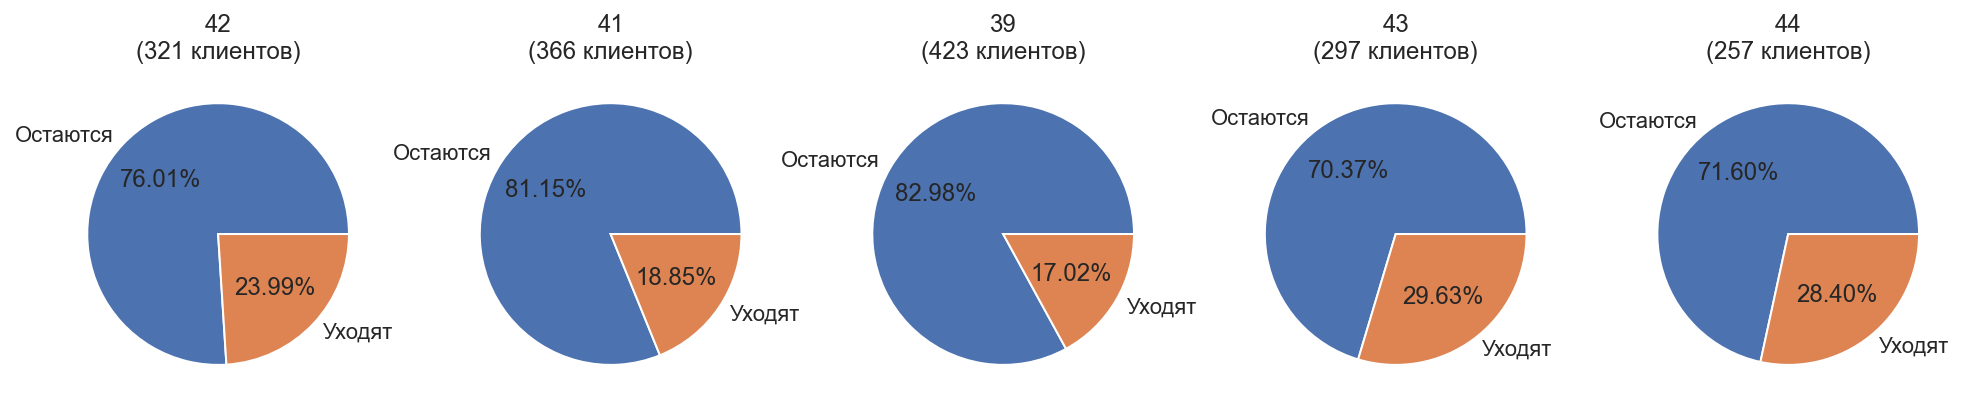

In [28]:
# построим круговые диаграммы
ages = df.groupby('age', as_index=False, sort=False )['churn'].sum().head().age.unique()

fig, axs = plt.subplots(1, len(ages), sharey=False, figsize=(17, 17))
for i, age in enumerate(ages):
    df_temp = df.query('age == @age').churn.value_counts()
    df_temp.plot(kind='pie',
                 ax=axs[i],
                 labels=['Остаются', 'Уходят'],
                 ylabel="",
                 autopct='%1.2f%%',
                ).set(title=f'{age}\n({df_temp.sum()} клиентов)')

plt.show()

*Мы составили рейтинг (Топ-5) оттока по возрасту, наибольший отток приходится на сорокалетних.*

<a id="num31"></a>
### Вывод.

*В результате исследования мы выявили признаки влияющие на отток клиентов:*
- *Большинство клиентов, которые ушли, не использовали других продуктов, кроме банковского счета — products_1*
- *Кредитный рейтинг 'score' ниже 400 влияет на отток, однако в целом, кредитный рейтинг не оказал большого влияния на отток клиентов.*
- *Вероятный возраст оттока приходится на 40 - 50 лет, причём женщины чаще уходят в отток.*
- *Из небольших городов, отток происходит чаще, чем из крупных.*

<a id="num4"></a>
## Проверка гипотез.

<a id="num41"></a>
### Проверим гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Выполним тест Колмогорова-Смирнова для проверки формы распределения, тест Шапиро-Уилка не подходит, так как записей у нас более 5000. 

В 'args' мы передаём параметры нормального распределения, с которым мы хотим сравнить распределение выборки (выборочное среднее и стандартное отклонения).

In [29]:
# тест Колмогорова-Смирнова
ks_salary = df['estimated_salary']
print(st.kstest(ks_salary,'norm',args=(ks_salary.mean(), ks_salary.std(ddof=1))))

KstestResult(statistic=0.05509558111983681, pvalue=7.972912704883877e-27)


**P-value < 0.05** *следовательно гипотеза о нормальности не принимается.*

Выберем статистический критерий:
- *тип данных - количественные*
- *тип распределения - ненормальное*
- *количество групп сравнения - 2*
- *группы сравнения между собой - не связаны (единицы наблюдения в группах различны)*

По этим парамерам мы выберем тест Манна-Уитни. Критерий Манна-Уитни является альтернативой ти-теста для двух независимых выборок и может применяться при любом типе распределения. Этот критерий проверяет гипотезу о том, что две выборки взяты из одной генеральной совокупности, в частности, насколько значения одной выборки больше чем в другой.

**Нулевая гипотеза H0:** Доход клиентов, которые пользуются одним подуктом не превосходит доход клиентов, которые которые пользуются двумя подуктами. <br>
**Альтернативная гипотеза H1:** Доход клиентов, которые пользуются одним подуктом отличается от дохода клиентов, которые которые пользуются двумя подуктами.

In [30]:
#Подготовим выборки к проверке критерием Манна-Уитни.
salary_A = df.query('products == 1')['estimated_salary']
salary_B = df.query('products == 2')['estimated_salary']

# критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу
alpha = .05

# применим статистический критерий Манна-Уитни к полученным выборкам
salary_results = st.mannwhitneyu(salary_A, salary_B, alternative='two-sided')[1]

colorRB('P-value: ', salary_results.round(3))

if salary_results < alpha:
    colorR('Отвергаем нулевую гипотезу')
else:
    colorR('Не получилось отвергнуть нулевую гипотезу')

 P-value:    0.408 
 Не получилось отвергнуть нулевую гипотезу 


*Таким образом, мы подтвердили гипотезу о равенстве доходов двух выборок:  <br>
средний доход между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним — ОДИНАКОВ.*

<a id="num42"></a>
### Проверим гипотезу различия кредитного рейтинга<br> между клиентами которые ушли и которые остались .

Выполним тест Колмогорова-Смирнова для проверки формы распределения.

In [31]:
# тест Колмогорова-Смирнова
ks_score = df['score']

print(st.kstest(ks_score,'norm',args=(ks_score.mean(), ks_score.std(ddof=1))))

KstestResult(statistic=0.01951926303573892, pvalue=0.0009679059703485127)


**P-value < 0.05** *следовательно гипотеза о нормальности не принимается.*

Выберем статистический критерий:
- *тип данных - количественные*
- *тип распределения - ненормальное*
- *количество групп сравнения - 2*
- *группы сравнения между собой - не связаны (единицы наблюдения в группах различны)*

По этим парамерам мы выберем тест Манна-Уитни.

**Нулевая гипотеза H0:** Средний кредитный рейтинг клиентов которые ушли не превосходит средний кредитный рейтинг клиентов которые остались.<br>
**Альтернативная гипотеза H1:** Средний кредитный рейтинг между клиентами которые ушли и которые остались отличается.

In [32]:
# сравним средние двух генеральных совокупностей t-тестом
score_A = df.query('churn == 1')['score']
score_B = df.query('churn == 0')['score']

# критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу
alpha = .05

# применим статистический критерий Манна-Уитни к полученным выборкам
score_results = st.mannwhitneyu(score_A, score_B, alternative='two-sided')[1]

colorRB('P-value: ', score_results.round(3))

if score_results < alpha:
    colorR('Отвергаем нулевую гипотезу')
else:
    colorR('Не получилось отвергнуть нулевую гипотезу')

 P-value:    0.02 
 Отвергаем нулевую гипотезу 


*Таким образом, мы отвергли гипотезу о равенстве средних значений двух выборок:  <br>
Средний кредитный рейтинг между клиентами которые ушли и которые остались — ОТЛИЧАЕТСЯ.*

<a id="num5"></a>
## Общий вывод и рекомендации.

**В результате исследования мы выявили признаки влияющие на отток клиентов:**<br>
- *`Сегмент «Город»` — Из небольших городов, отток происходит чаще, чем из крупных:*
 - *Рекомендации: В небольших городах создать льготные условия для держателей кредитных карт:* 
   - *увеличить процент на остаток,*
   - *увеличить льготный период;*
- *`Сегмент «Кредитный рейтинг»` — Кредитный рейтинг ниже 400 влияет на отток, однако в целом, кредитный рейтинг не оказал большого влияния на отток клиентов:*
 - *При помощи небольших кредитов, постепенно повышать кредитный рейтинг.*
- *`Сегмент «Возраст»` — Вероятный возраст оттока приходится на 40 - 50 лет:*
 - *Рекомендации: Для держателей зарплатных карт создать специальные условия кредитования:*
   - *пониженные процентные ставки по кредитным продуктам;*
   - *отсутствие комиссий;*
   - *рассмотрение заявок в кратчайшие сроки;*
   - *минимальный пакет документов;*
   - *возможность подать заявку на кредит без посещения офиса Банка.*
- *`Сегмент «Пол»` — женщины чаще уходят в отток:*
 - *Рекомендации: Стимулировать приобретение женщинами кредитных карт:*
   - *кешбек на женские категории товаров в популярных маркетплейсах.*
- *`Сегмент «Количество продуктов»` — Большинство клиентов, которые ушли, не использовали других продуктов, кроме банковского счета:*
 - *Рекомендации: Стимулировать приобретение клиентами кредитных карт:*
   - *Распространять бесплатную брощюру с пояснением правил и выгоды от использования кредитной карты.*

**Также мы проверили гипотезы и выяснили, что:**<br>
- *Средний доход не влияет на принятие решения о приобретении второго продукта.*
- *Кредитный рейтинг оказывает влияние на отток клиентов.*<br><br>

**Дополнительно:**<br>
- *изучить, почему при использовании 4 продуктов у клиентов возникает 100% отток (является ли отток свойством продукта, например погашение кредита или ипотеки).*
- *пропуски в значениях колонки 'balance', видимо связаны с ошибкой заполнения данных в городах Ярославль и Рыбинск, когда кредитная карта с нулевым балансом, ошибочно принимается за дебетовую.*

<a id="num6"></a>
## Подготовка презентации.

Презентация: https://disk.yandex.ru/i/FKKovQFh2dGfMw

Дашборд, Набор №1: https://public.tableau.com/views/Book2_16586728168660/sheet0?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link